# **Apple Identification Model** 

See the [README.md](README.md) for a full project overview, setup instructions, and additional context.

## **Imports**

In [90]:
# Database API
from kaggle.api.kaggle_api_extended import KaggleApi

# File and directory management
import os
import json
import shutil
from typing import TypedDict
from pathlib import Path

# Data manipulation
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Computer vision
import cv2

# Machine learning
import tensorflow as tf

# Keras for deep learning
from keras.applications import MobileNetV2
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPool2D, GlobalAveragePooling2D, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [74]:
import tensorflow as tf
print("GPUs:", tf.config.list_physical_devices('GPU'))

GPUs: []


## **Table of Contents**

[**Dataset**](#dataset) — Overview of the dataset and filtering process

- [**Filtering Data**](#filtering-data) — Selecting only apple images from the full dataset  
- [**Data Preprocessing**](#data-preprocessing) — Cleaning and organizing the apple dataset for training  
- [**Dataset Structure**](#dataset-structure) — Explaining the layout of the training, test, and validation sets  
- [**Examples of Each Species**](#examples-of-each-species) — Visualizing the apple species in the dataset  
  
[**Model**](#model) — CNN architecture for apple species classification

- [**Model Architecture**](#model-architecture) — Structure and layers of the neural network  
- [**Training**](#training) — Optimizer, loss function, and training parameters  
- [**Evaluation**](#evaluation) — Accuracy, loss, and model performance analysis  

[**Results**](#results) — Final performance metrics and visualizations

[**Conclusion**](#conclusion) — Summary of results and future work

## **Dataset**

The dataset used in this project is the **Fruits360** dataset from Kaggle, which contains images of a wide variety of fruits. For the purposes of this project, the dataset will be filtered to include only apples and their different varieties.

### **Filtering Data**

The original dataset contains a wide variety of fruit images, but for this project, we are only interested in apple images.

In this step, we will:
- Download the full fruit dataset using the Kaggle API
- Filter out only the apple-related data
- Create a clean, organized apple-only dataset to use for training and evaluation

In [75]:
kaggle_api = KaggleApi()
kaggle_api.authenticate()

dataset = Path('fruits_dataset')

if dataset.is_dir():
    print('Fruits dataset already downloaded')
else:
    print('Downloading fruits dataset')
    kaggle_api.dataset_download_files('moltean/fruits', path=dataset, unzip=True)

Fruits dataset already downloaded


In [76]:
dataset = dataset / 'fruits-360_100x100/fruits-360'

apple_dataset = Path('apple_dataset')

apple_species = [
    'apple braeburn', 
    'apple crimson snow',
    'apple golden', 
    'apple granny smith', 
    'apple hit',
    'apple pink lady',
    'apple red', 
    'apple red delicious',
    'apple red yellow'
]

print(f'{len(apple_species)} species of apples:')
for species in apple_species:
    print(f'  - {species.replace("apple ", "").title()}')

9 species of apples:
  - Braeburn
  - Crimson Snow
  - Golden
  - Granny Smith
  - Hit
  - Pink Lady
  - Red
  - Red Delicious
  - Red Yellow


### **Data Preprocessing**

Fortunately, the dataset was already split into training, validation, and test sets, which simplifies the initial setup.

**TODO:**
- Create a filtered dataset containing only apple species
- Relabel folders as needed and remove any irrelevant or unwanted data

In [77]:
def is_apple_species(name: str, species: list[str]) -> bool:
    return any(specie in name.lower() for specie in species)

def copy_apple_dirs(source_dir: Path, dest_dir: Path, species_list=apple_species):
    for dir in source_dir.iterdir():
        if (dir.is_dir() 
            and is_apple_species(dir.name, species_list) 
            and not (dest_dir / dir.name).exists()
        ):
            shutil.copytree(dir, dest_dir / dir.name)

In [78]:
# Create apple dataset
apple_trainning = Path(apple_dataset / 'train')
copy_apple_dirs(dataset / 'Training', apple_trainning)

apple_testing = Path(apple_dataset / 'test')
copy_apple_dirs(dataset / 'Test', apple_testing)

**Possible Future work:**
- Combine duplicate species, for example: `golden_1`, `golden_2`, `golden_3` $\longrightarrow$ `golden`
- Relabel imgs to more explicit labels, for example: `r0_1.jpg` $\longrightarrow$ `roation_0_golden_1.jpg`
- Add more apples from other datasets

### **Dataset Structure**

**[2025-03-23]** — The dataset currently mirrors the structure of the original source in order to maintain clarity and consistency during this initial phase of model development. Future changes to the structure may be implemented as needed and will be documented here.

Each folder represents a distinct apple species class. In some cases, duplicate species are split into separate folders (e.g., `golden_1` and `golden_2`). Image filenames include rotation labels along the third axis, noted as `r0` or `r1`.

The dataset is divided into three subsets:
- **Training** contains `k + 2` images per apple
- **Validation** contains `k + 1` images
- **Test** contains `k + 3` images

This results in the training set comprising approximately 50% of the total images, while the validation and test sets each contain around 25%.

---

**[2025-04-17]** - The dataset was previously based of the directory found under `fruits-360_original-size` which proved to be a difficult dataset to train on so the dataset has been updated to be based on the `fruits-360_100x100` dataset which has proven to be significantly better at identifiying apple species.

It appears the trainning and test images are completly randomized possibly a pattern of primes and composite numbers but would need to look into it further


### **Examples of Each Species**

The following images are examples of the apple species included in the dataset. Each image is labeled with its corresponding species name.

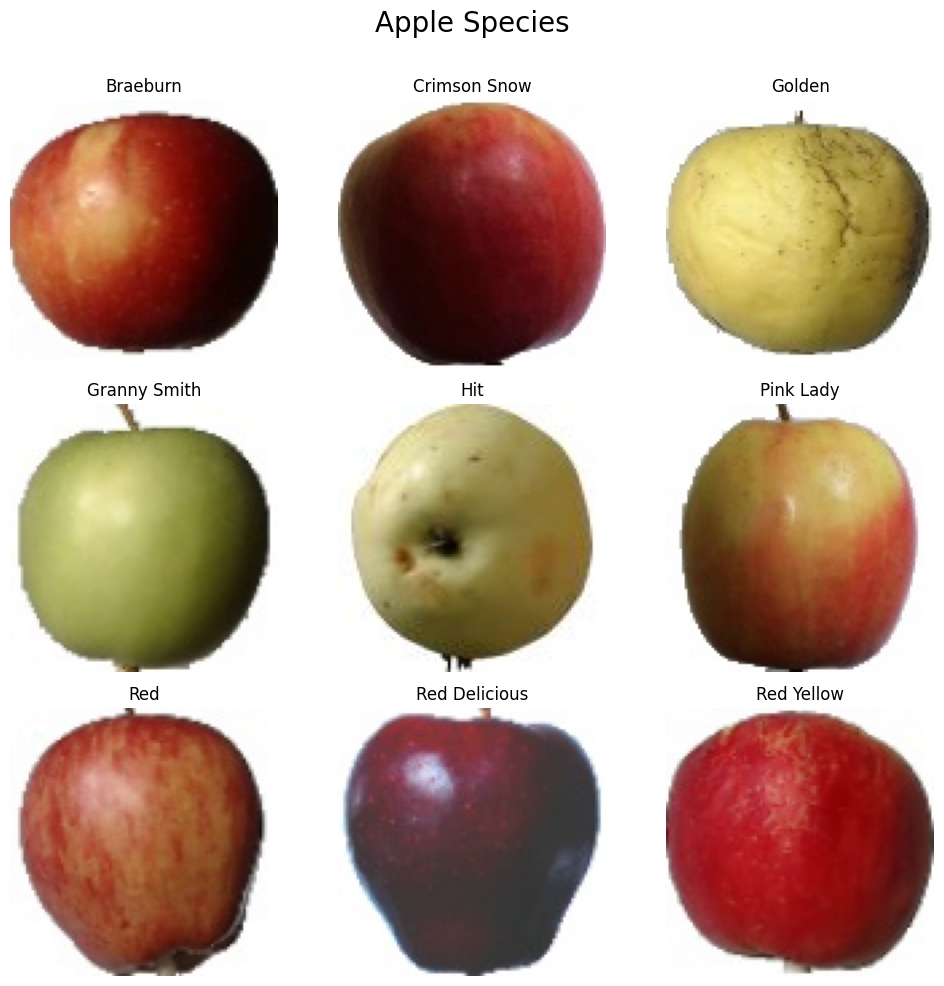

In [131]:
# Display one image from each apple species in a 3x3 grid

def normalize_name(name: str) -> str:
    # lowercase → split by space → drop trailing number if it's a digit
    name = name.lower().strip()
    parts = name.split()
    if parts and parts[-1].isdigit():
        parts = parts[:-1]
    return ' '.join(parts)

def get_imgs(apple_dataset: Path, apple_species: list[str]):
    seen_species = set()
    info = []
    normalized_species_set = {normalize_name(name) for name in apple_species}
    
    for dir in sorted(apple_dataset.iterdir()):
        if dir.is_dir():
            species_name = normalize_name(dir.name)
            if species_name in normalized_species_set and species_name not in seen_species:
                for img in dir.iterdir():
                    if img.suffix.lower() in ['.jpg', '.jpeg', '.png']:
                        info.append((species_name, img))
                        seen_species.add(species_name)
                        break

    return sorted(info, key=lambda x: apple_species.index(x[0]))

def display_apple_species(apple_dataset: Path, apple_species: list[str]):
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # ← smaller figure
    fig.suptitle('Apple Species\n', fontsize=20)
    axes = axes.flatten()
    img_paths = get_imgs(apple_dataset, apple_species)

    for ax, (name, img_path) in zip(axes, img_paths):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.set_title(name.replace('apple ', '').title(), fontsize=12)  # smaller font
        ax.axis('off')

    for ax in axes[len(img_paths):]:
        ax.axis('off')

    plt.tight_layout(pad=1.0)
    plt.show()


# Display the apple species
display_apple_species(apple_trainning, apple_species=apple_species)


## **Model** 

For this project I will be using a CNN (Convolutional Neural Network) architecture to classify the apple species. 

### **Model Architecture**

In [ ]:
# ---------------------------------- CONFIG ---------------------------------- #

BATCH_SIZE = 64
EPOCHS = 50
TARGET_SIZE = (100, 100, 3)  

# ------------------------------- DATA LOADING ------------------------------- #

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.3
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    apple_trainning,
    target_size=(100, 100),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    apple_testing,
    target_size=(100, 100),
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    class_mode='categorical'
)

steps_per_epoch = int(np.ceil(train_generator.samples / BATCH_SIZE))
validation_steps = int(np.ceil(test_generator.samples / BATCH_SIZE))

# --------------------------------- MODEL ---------------------------------- #

cnn = Sequential([
            Input(shape=TARGET_SIZE),
            Conv2D(128, kernel_size=3, activation='relu'),
            MaxPool2D(),
            Conv2D(64, kernel_size=3, activation='relu'),
            Conv2D(32, kernel_size=3, activation='relu'),
            MaxPool2D(),
            Dropout(0.5),
            Flatten(),
            Dense(5000, activation='relu'),
            Dense(1000, activation='relu'),
            Dense(train_generator.num_classes, activation='softmax')
        ])

# ---------------------------------- COMPILE --------------------------------- #

cnn.compile(
    optimizer='SGD', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
    )

# --------------------------------- CALLBACKS -------------------------------- #

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

# ----------------------------------- TRAIN ---------------------------------- #

history = cnn.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=[early_stopping]
)

# ----------------------------- SAVE THE MODEL ----------------------------- #

cnn.save("cnn_apple_classifier.keras")

with open('cnn_training.json', 'w') as f:
    json.dump(history.history, f, indent=4)

Found 7106 images belonging to 14 classes.
Found 2368 images belonging to 14 classes.


c:\Users\robbykap\miniconda3\envs\tf-gpu\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 246ms/step - accuracy: 0.1091 - loss: 2.6008 - val_accuracy: 0.3429 - val_loss: 2.0874
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 28s 246ms/step - accuracy: 0.2671 - loss: 2.0649 - val_accuracy: 0.4033 - val_loss: 1.6490
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 239ms/step - accuracy: 0.3920 - loss: 1.6469 - val_accuracy: 0.5279 - val_loss: 1.2712
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 242ms/step - accuracy: 0.4960 - loss: 1.4145 - val_accuracy: 0.5460 - val_loss: 1.1849
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 243ms/step - accuracy: 0.5798 - loss: 1.1906 - val_accuracy: 0.6140 - val_loss: 0.9520
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 242ms/step - accuracy: 0.6130 - loss: 1.1180 - val_accuracy: 0.6579 - val_loss: 0.9343
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 243ms/step - accuracy: 0.7027 - loss: 0.8447 - val_accuracy: 0.7466 - val_loss: 0.6909
Epoch 8/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 27s 242ms/step - accuracy: 0.7129 - loss: 0

### **Training**

In [ ]:
# ---------------------- CONFIG ---------------------- #

BATCH_SIZE = 64
EPOCHS = 50
TARGET_SIZE = (100, 100, 3)

# -------------------- DATA LOADING ------------------ #

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.3
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    apple_trainning, 
    target_size=(100, 100),
    batch_size=BATCH_SIZE,
    color_mode = 'rgb',
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    apple_testing,  
    target_size=(100, 100),
    batch_size=BATCH_SIZE,
    color_mode = 'rgb',
    class_mode='categorical'
)

steps_per_epoch = int(np.ceil(train_generator.samples / BATCH_SIZE))
validation_steps = int(np.ceil(test_generator.samples / BATCH_SIZE))

# ---------------------- MODEL ------------------------ #

base_model_net = MobileNetV2(
    input_shape=(TARGET_SIZE),
    include_top=False,
    weights='imagenet'
)
base_model_net.trainable = False  # Freeze base model for now

# Add custom classification head
x = base_model_net.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(train_generator.num_classes, activation='softmax')(x)

mobileNet = Model(inputs=base_model_net.input, outputs=outputs)

# -------------------- COMPILE ------------------------ #

mobileNet.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# -------------------- CALLBACKS ---------------------- #

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)

# ---------------------- TRAIN ------------------------ #

history = mobileNet.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=validation_steps,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# ---------------------- SAVE ------------------------ #

mobileNet.save("mobilenetv2_apple_classifier.keras")

with open('mobilenet_training.json', 'w') as f:
    json.dump(history.history, f, indent=4)


Found 7106 images belonging to 14 classes.
Found 2368 images belonging to 14 classes.


C:\Users\robbykap\AppData\Local\Temp\ipykernel_79828\2317112903.py:41: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_net = MobileNetV2(


Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 18s 127ms/step - accuracy: 0.5078 - loss: 1.6311 - val_accuracy: 0.8552 - val_loss: 0.3570 - learning_rate: 0.0010
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - accuracy: 0.8512 - loss: 0.4131 - val_accuracy: 0.9286 - val_loss: 0.2172 - learning_rate: 0.0010
Epoch 3/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - accuracy: 0.8951 - loss: 0.3039 - val_accuracy: 0.9223 - val_loss: 0.2153 - learning_rate: 0.0010
Epoch 4/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 113ms/step - accuracy: 0.9063 - loss: 0.2579 - val_accuracy: 0.9253 - val_loss: 0.2004 - learning_rate: 0.0010
Epoch 5/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - accuracy: 0.9197 - loss: 0.2337 - val_accuracy: 0.8991 - val_loss: 0.3002 - learning_rate: 0.0010
Epoch 6/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.9301 - loss: 0.1923 - val_accuracy: 0.9109 - val_loss: 0.2682 - learning_rate: 0.0010
Epoch 7/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.9

### **Evaluation**

In [ ]:
# -------------------------------- MODEL PATHS ------------------------------- #

CNN_MODEL_PATH = Path("cnn_apple_classifier.keras")
MOBILENET_MODEL_PATH = Path("mobilenetv2_apple_classifier.keras")

# ----------------------------- TRAINING HISTORY ----------------------------- #

CNN_HISTORY_PATH = Path("cnn_training.json")
MOBILENET_HISTORY_PATH = Path("mobilenet_training.json")

# ------------------------------ TYPE DEFINITIONS ---------------------------- #

class TrainingHistory(TypedDict):
    accuracy: list[float]
    loss: list[float]
    val_accuracy: list[float]
    val_loss: list[float]

CNNTrainingHistory = TrainingHistory

class MobileNetTrainingHistory(TrainingHistory):
    learning_rate: list[float]

# -------------------------------- LOAD HISTORY ------------------------------ #

with open(CNN_HISTORY_PATH, 'r') as f:
    cnn_history: CNNTrainingHistory = json.load(f)

with open(MOBILENET_HISTORY_PATH, 'r') as f:
    mobilenet_history: MobileNetTrainingHistory = json.load(f)

# -------------------------- PLOT TRAINING FUNCTION -------------------------- #

def plot_comparison(histories: dict[str, dict[str, list[float]]], metrics: list[str] = ["accuracy", "loss"]):
    """
    Plots superimposed training and validation curves for multiple models.
    Each model gets its own color; solid line = train, dashed line = val.
    """
    model_colors = [
        "#1f77b4",  # blue
        "#d62728",  # red
    ]

    model_names = list(histories.keys())
    color_map = {model: model_colors[i % len(model_colors)] for i, model in enumerate(model_names)}

    for metric in metrics:
        plt.figure()

        for name in model_names:
            history = histories[name]
            color = color_map[name]

            if metric in history:
                plt.plot(history[metric], label=f"{name} Train", color=color, linestyle='-')
            if f"val_{metric}" in history:
                plt.plot(history[f"val_{metric}"], label=f"{name} Val", color=color, linestyle='--')

        plt.title(f"{metric.capitalize()} Comparison")
        plt.xlabel("Epoch")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Optional: learning rate plot
    if any("learning_rate" in h for h in histories.values()):
        plt.figure()
        for name in model_names:
            history = histories[name]
            if "learning_rate" in history:
                plt.plot(history["learning_rate"], label=f"{name} LR", color=color_map[name])
        plt.title("Learning Rate Comparison")
        plt.xlabel("Epoch")
        plt.ylabel("Learning Rate")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


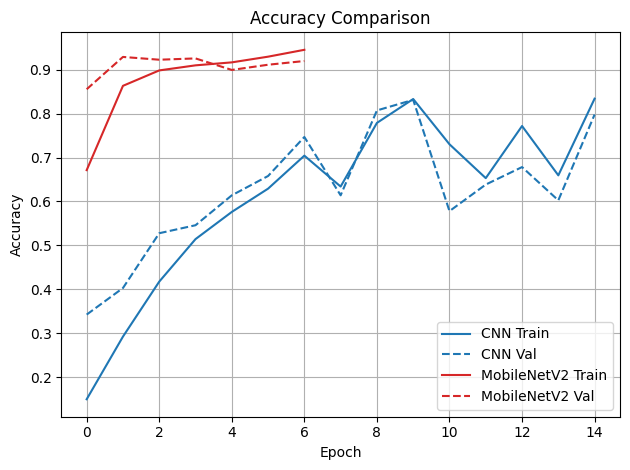

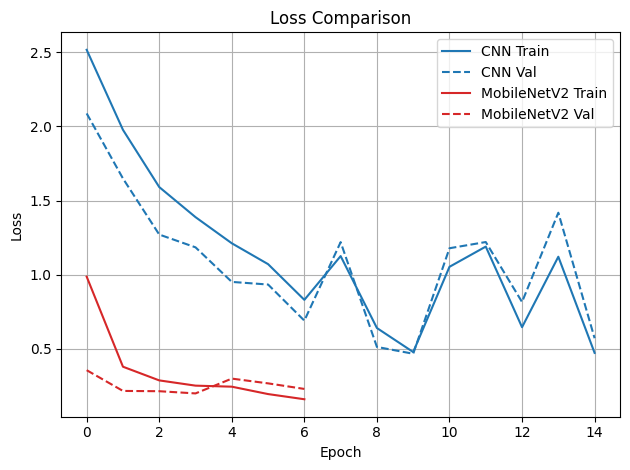

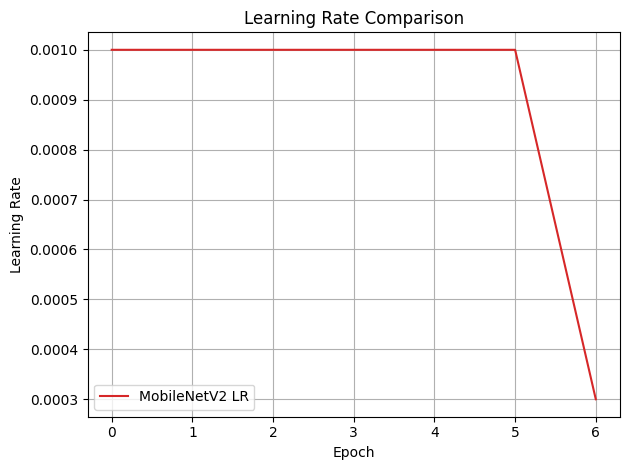

In [108]:
plot_comparison({
    "CNN": cnn_history,
    "MobileNetV2": mobilenet_history
})

### **Application**

## **Results**

## **Conclusion**